In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from global_land_mask import globe
from scipy.optimize import curve_fit
import matplotlib as mpl
import netCDF4
import metpy.calc as mpcalc
from metpy.units import units
import metpy
mpl.rcParams['figure.dpi']= 500

In [2]:
h = '/media/rakshith/Seagate Expansion Drive/mraks/TGMS ERA 1959-2021, India only.nc'
#h = '/media/rakshith/Windows/Users/mraks/TGMS ERA 1959-2021, India only.nc'
ds = xr.open_dataset(h)

In [4]:
lon_grid, lat_grid = np.meshgrid(ds.longitude, ds.latitude)
mask = globe.is_land(lat_grid, lon_grid)

In [5]:
jjas = ds.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds.sel(time=jjas)
clim = clim.groupby('time.year').mean('time')
clim3 = clim.where(mask>0).mean(dim=['latitude', 'longitude'])

In [70]:
Pwat = clim3.tcwv
E = -86400*28.96*clim3.mer
P = 86400*28.96*(clim3.mtpr+clim3.mer)
Qdiv = clim3.mtnswrf + clim3.mtnlwrf
TGMS = np.divide(Qdiv, P)
rec = np.divide(1, Pwat)

# choose the input and output variables
x1, y1 = rec.values, TGMS.values
 
# define the true objective function
def objective(x, a, b, c):
	return a * x**2 + b * x + c

popt1, _ = curve_fit(objective, x1, y1)
# summarize the parameter values
a1, b1, c1 = popt1

print('y = %.5f * x\u00b2 + %.5f * x + %.5f' % (a1, b1, c1)) #ERA5

x_line = np.linspace(np.min(x1), np.max(x1), 100)
y_line1 = objective(x_line, a1, b1, c1)

y = 17743.69202 * x² + -641.09950 * x + 6.12321


Text(0.5, 1.0, 'JJAS average 1959-2021')

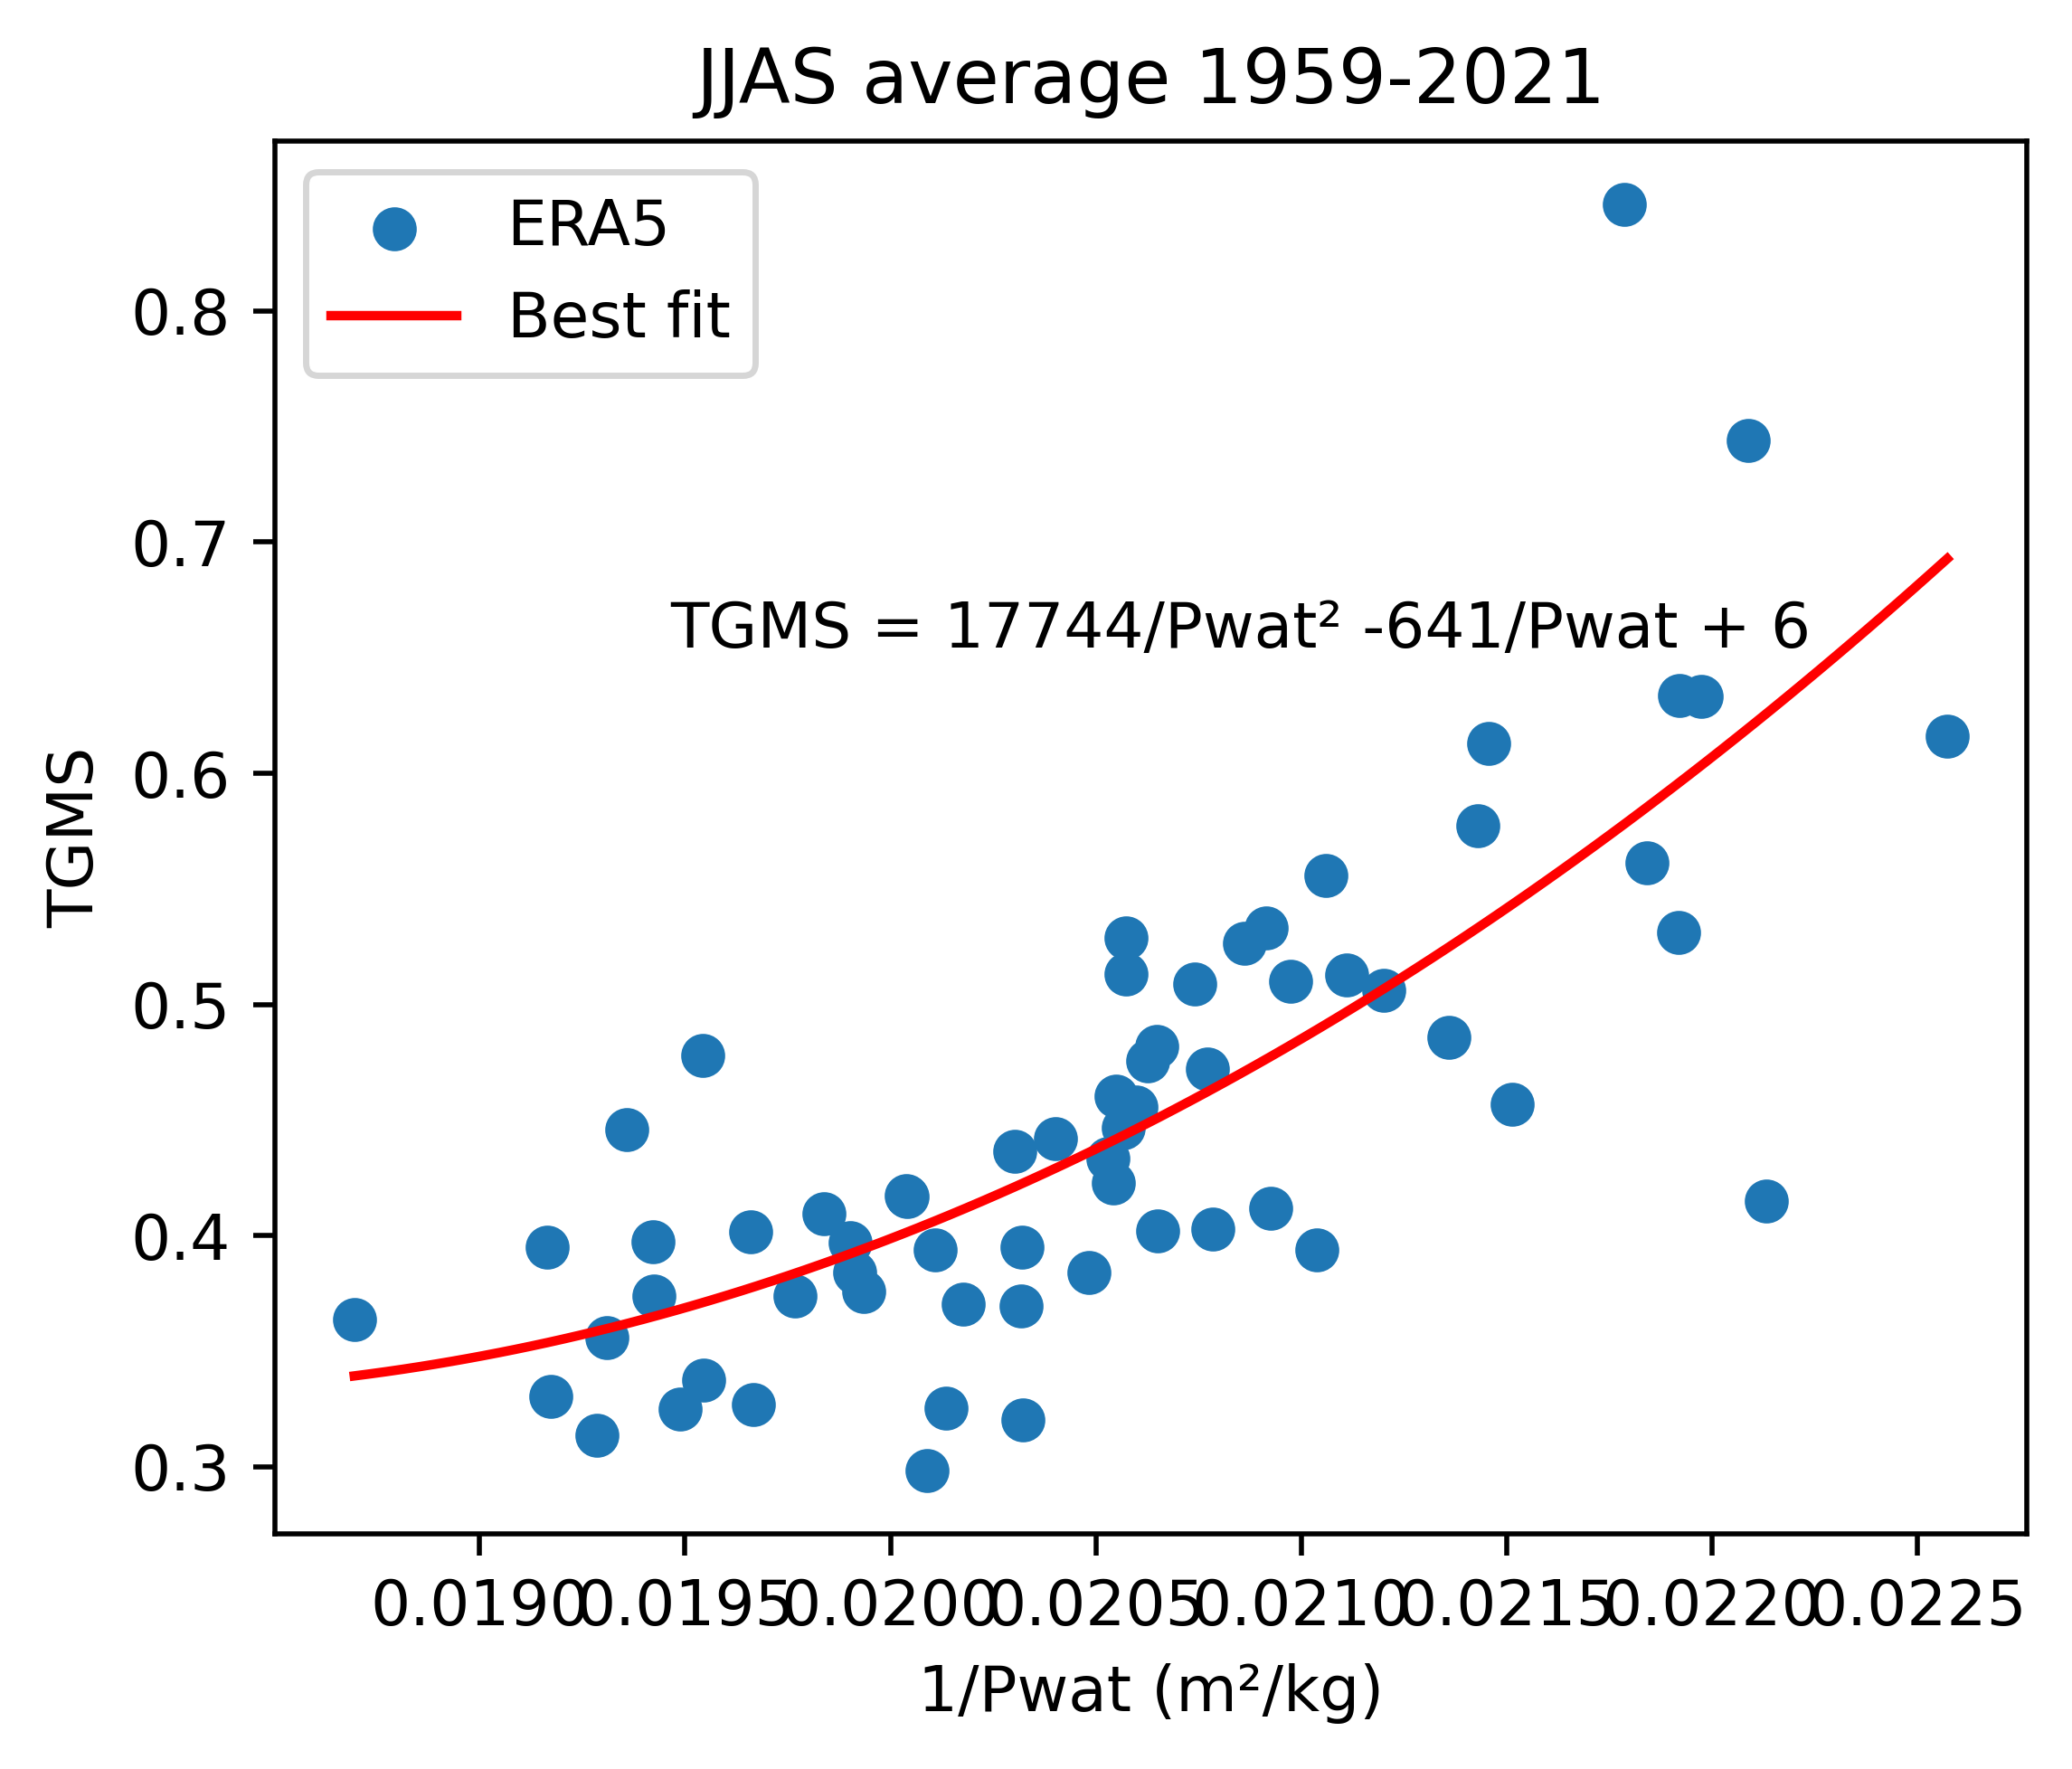

In [62]:
plt.rcParams['figure.figsize'] = [5,4]
plt.scatter(rec, TGMS, label ='ERA5')
plt.plot(x_line, y_line1, color='red', label = "Best fit")
plt.ylabel('TGMS')
plt.xlabel('1/Pwat (m\u00b2/kg)')
plt.figtext(0.3, 0.6, 'TGMS = %0.f/Pwat\u00b2 %0.f/Pwat + %0.f' %(a1, b1, c1))
plt.legend()
plt.title('JJAS average 1959-2021')

In [63]:
import scipy.optimize as opt

In [64]:
y_line1 = objective(np.array(x1), a1, b1, c1) #These are calculated TGMS values

Pcal = []
for i in range(len(P)):
	Pcal.append(Qdiv[i]/y_line1[i])

X1 = np.linspace(1959, 2014, 56, dtype='int')

def f(X, c1, c2):
	x1,y1 = X
	return (x1*y1)/(c1-c2*y1)

p0 = 80, 1
X1=Qdiv
Y1=Pwat
Z1=P
popt1, pcov1 = opt.curve_fit(f, (X1, Y1), Z1, p0)

c1, c2= popt1

pred1 = np.array([])
for i in range(len(P)):
	pred1 = np.append(pred1, (X1[i]*Y1[i])/(c1-c2*Y1[i]))

In [65]:
X = np.linspace(1959, 2021, 63, dtype='int')

In [66]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(P/28.96, np.array(Pcal)/28.96, squared=False)
rmse = mean_squared_error(P/28.96, pred1/28.96, squared=False)
print(rmse)

0.5928937360975833


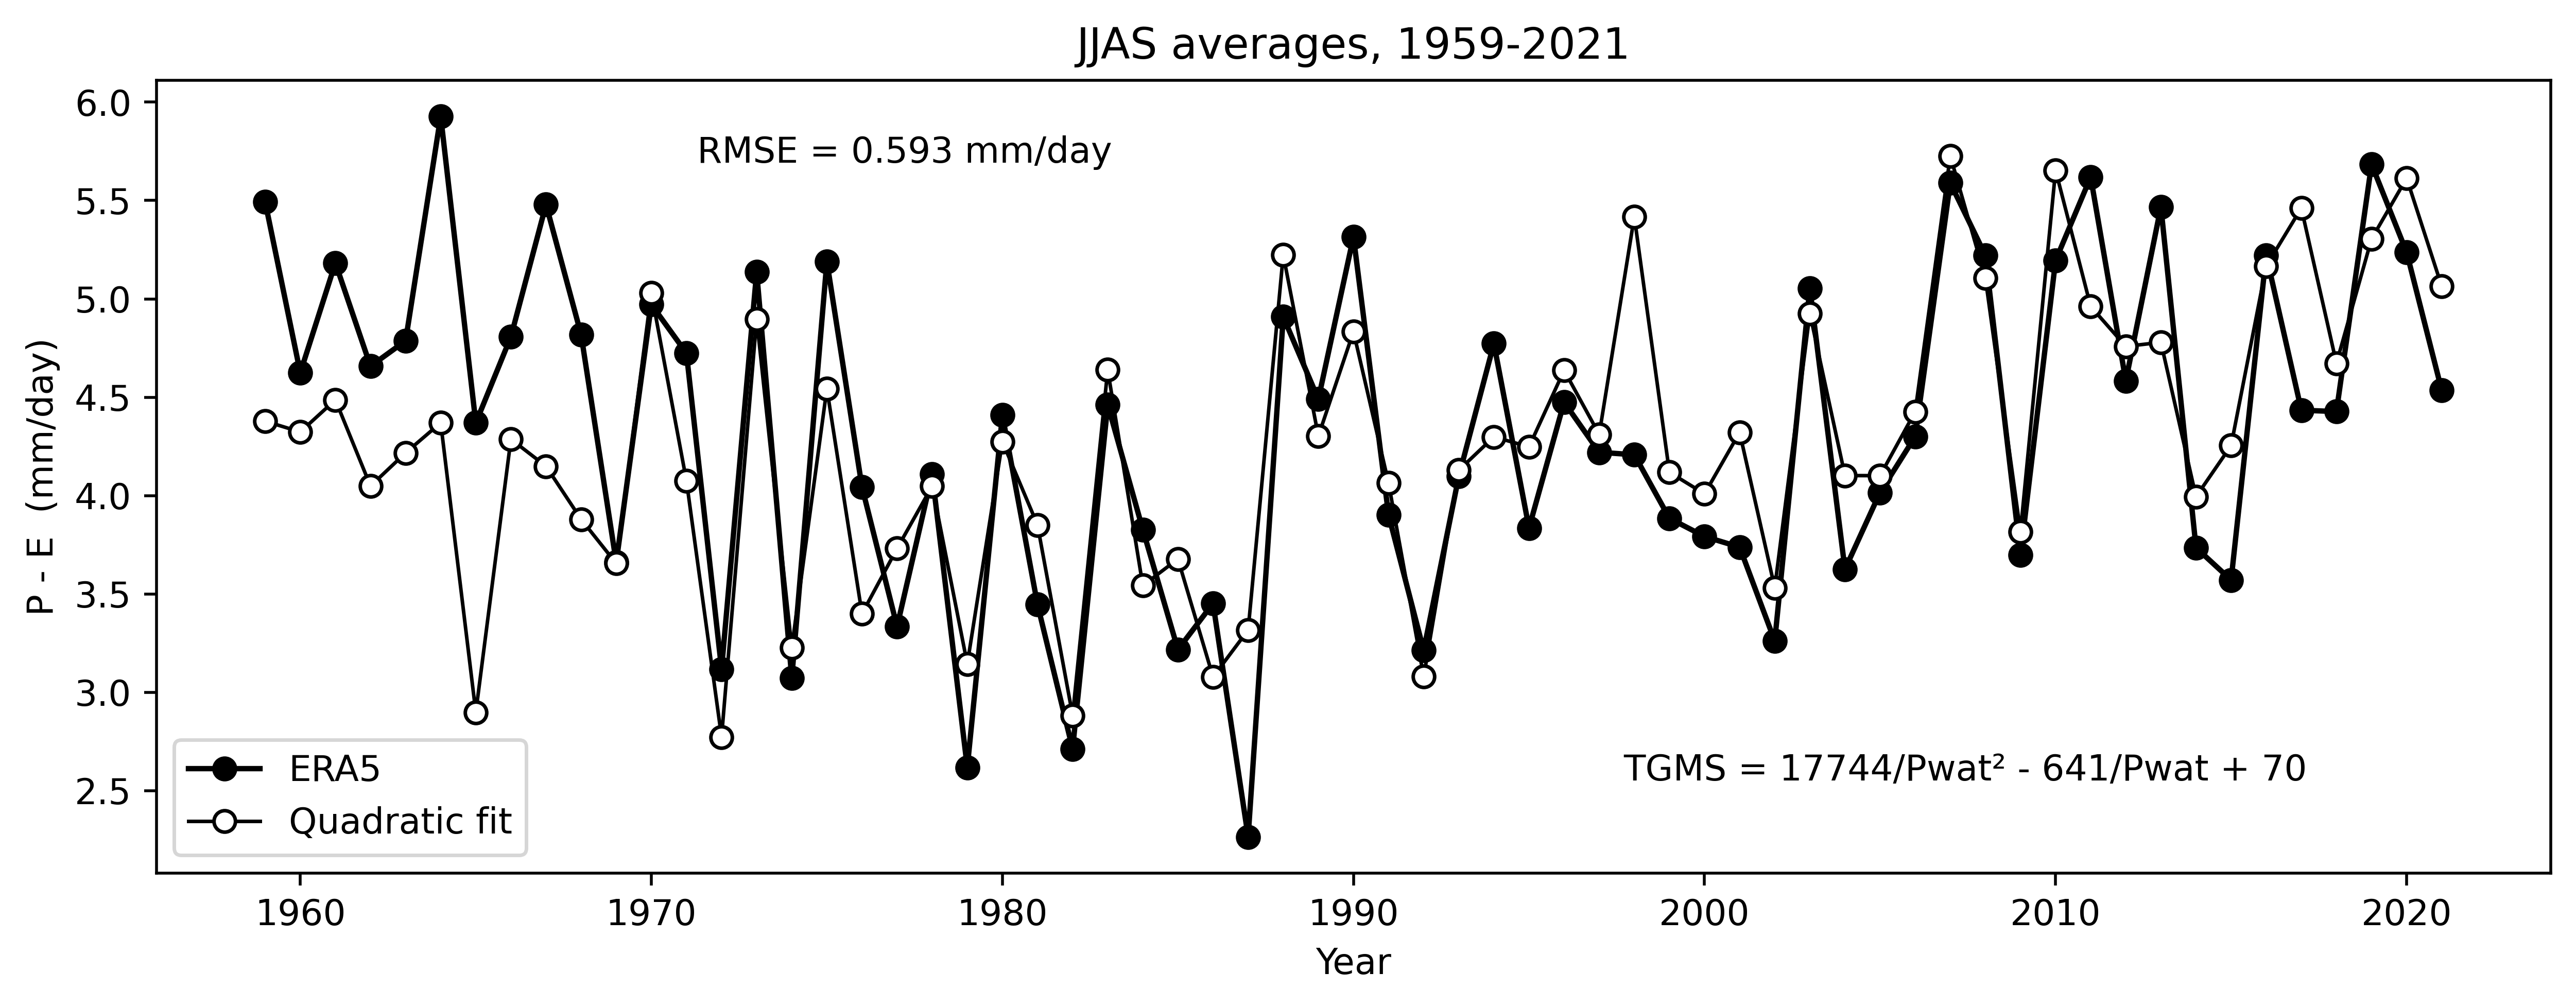

In [67]:
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(X, P/28.96, color='black', label = 'ERA5', marker='o')
plt.plot(X, np.array(Pcal)/28.96, c='black', marker='o', markerfacecolor='white', linewidth=1, label='Quadratic fit')
plt.xlabel('Year')
plt.ylabel('P - E  (mm/day)')
plt.figtext(0.6, 0.2, 'TGMS = %0.f/Pwat\u00b2 - %0.f/Pwat + %0.f' %(a1, abs(b1), c1))
plt.legend()
#plt.xticks(X, X)
#plt.xticks(rotation=90)
plt.figtext(0.3, 0.8, 'RMSE = %.3f mm/day' %(rmse))
plt.title('JJAS averages, 1959-2021')
plt.show()

In [14]:
PTGMS = np.multiply(TGMS, Pwat)

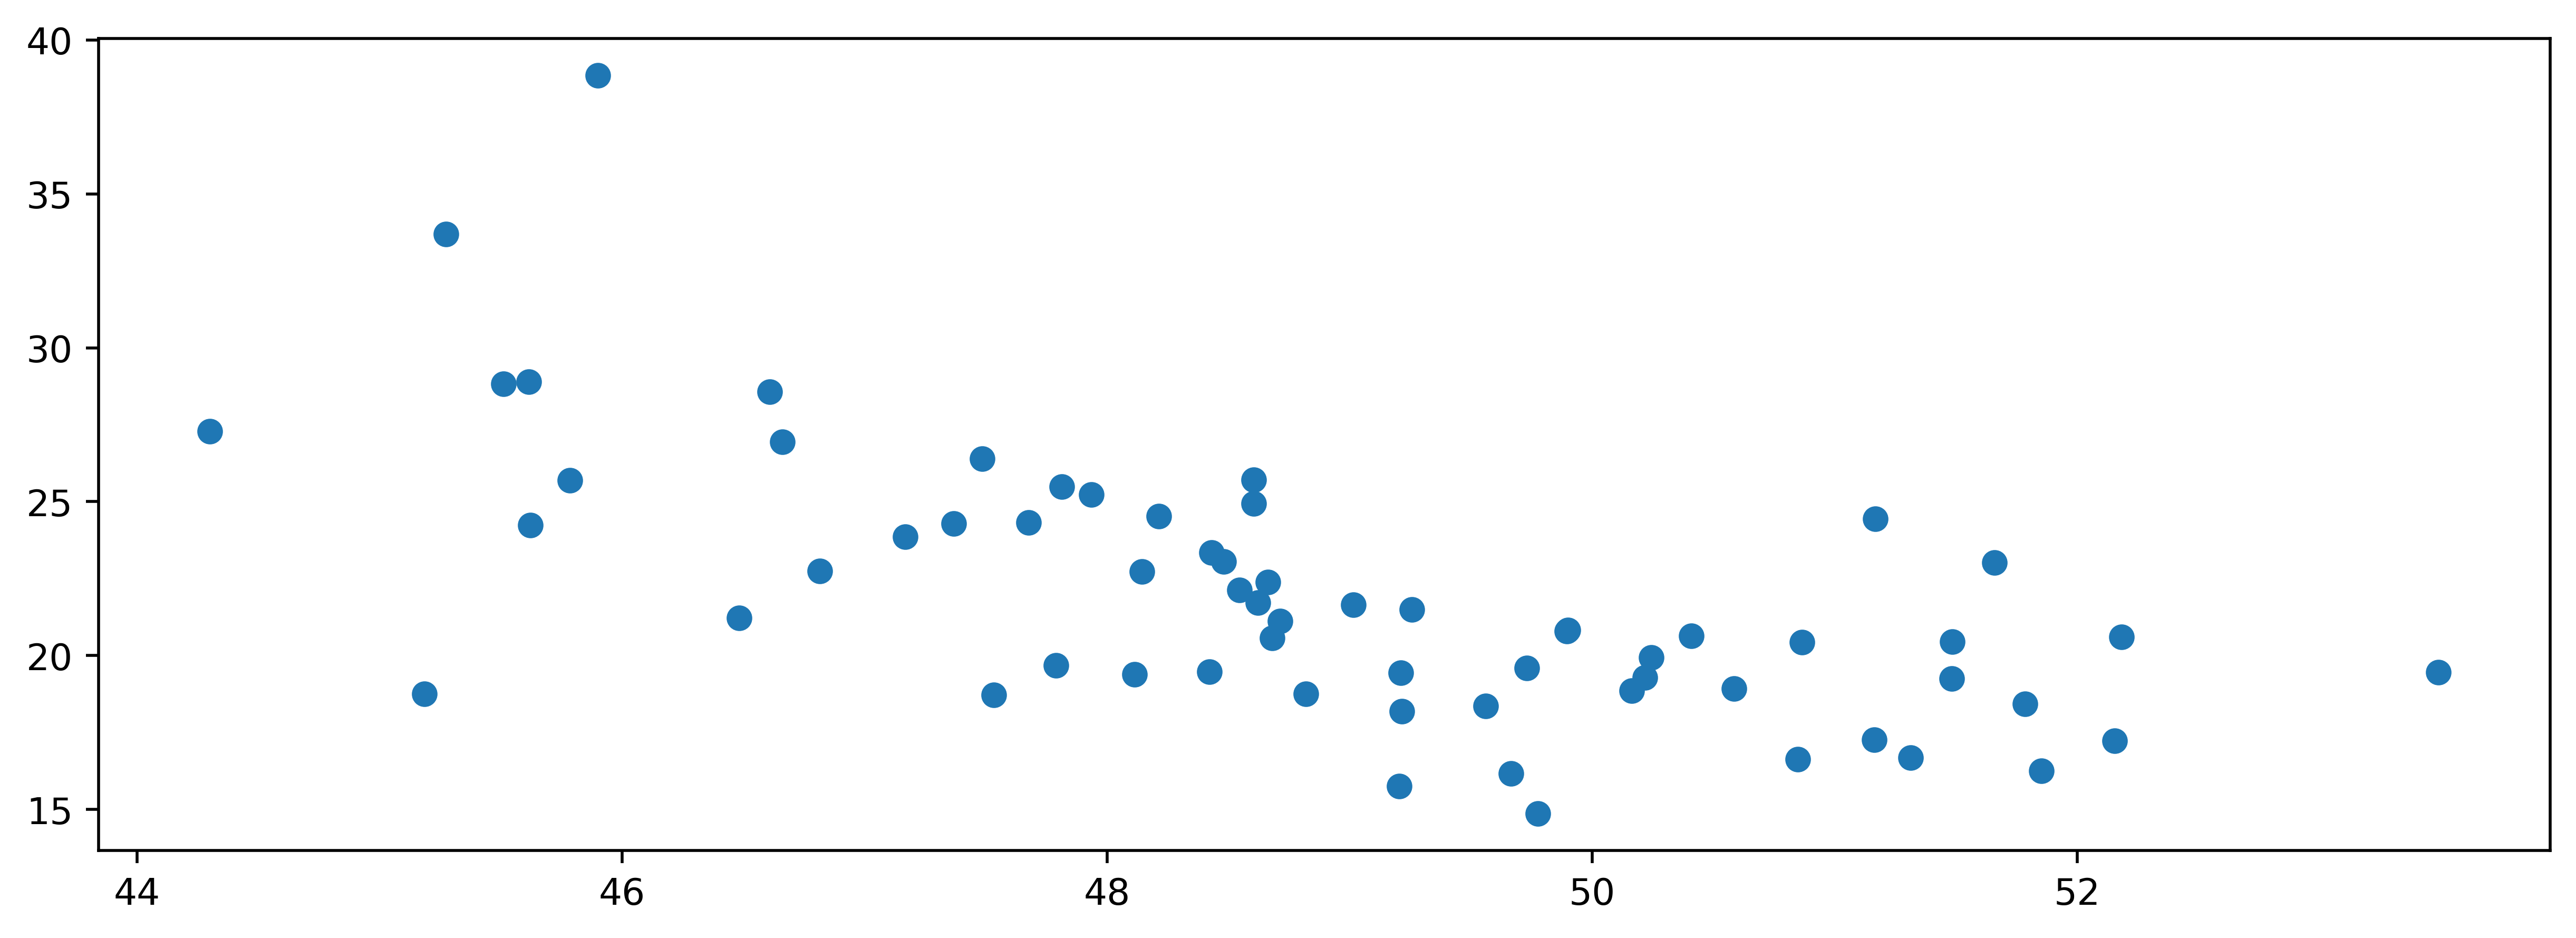

In [15]:
plt.scatter(Pwat, PTGMS)

# JJAS plot

In [92]:
C = 72.2214

In [93]:
Pcal = (E + Qdiv/((C/Pwat)-1))/28.96

In [94]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(86400*clim3.mtpr, Pcal, squared=False)
print(rmse)

0.7029132414134462


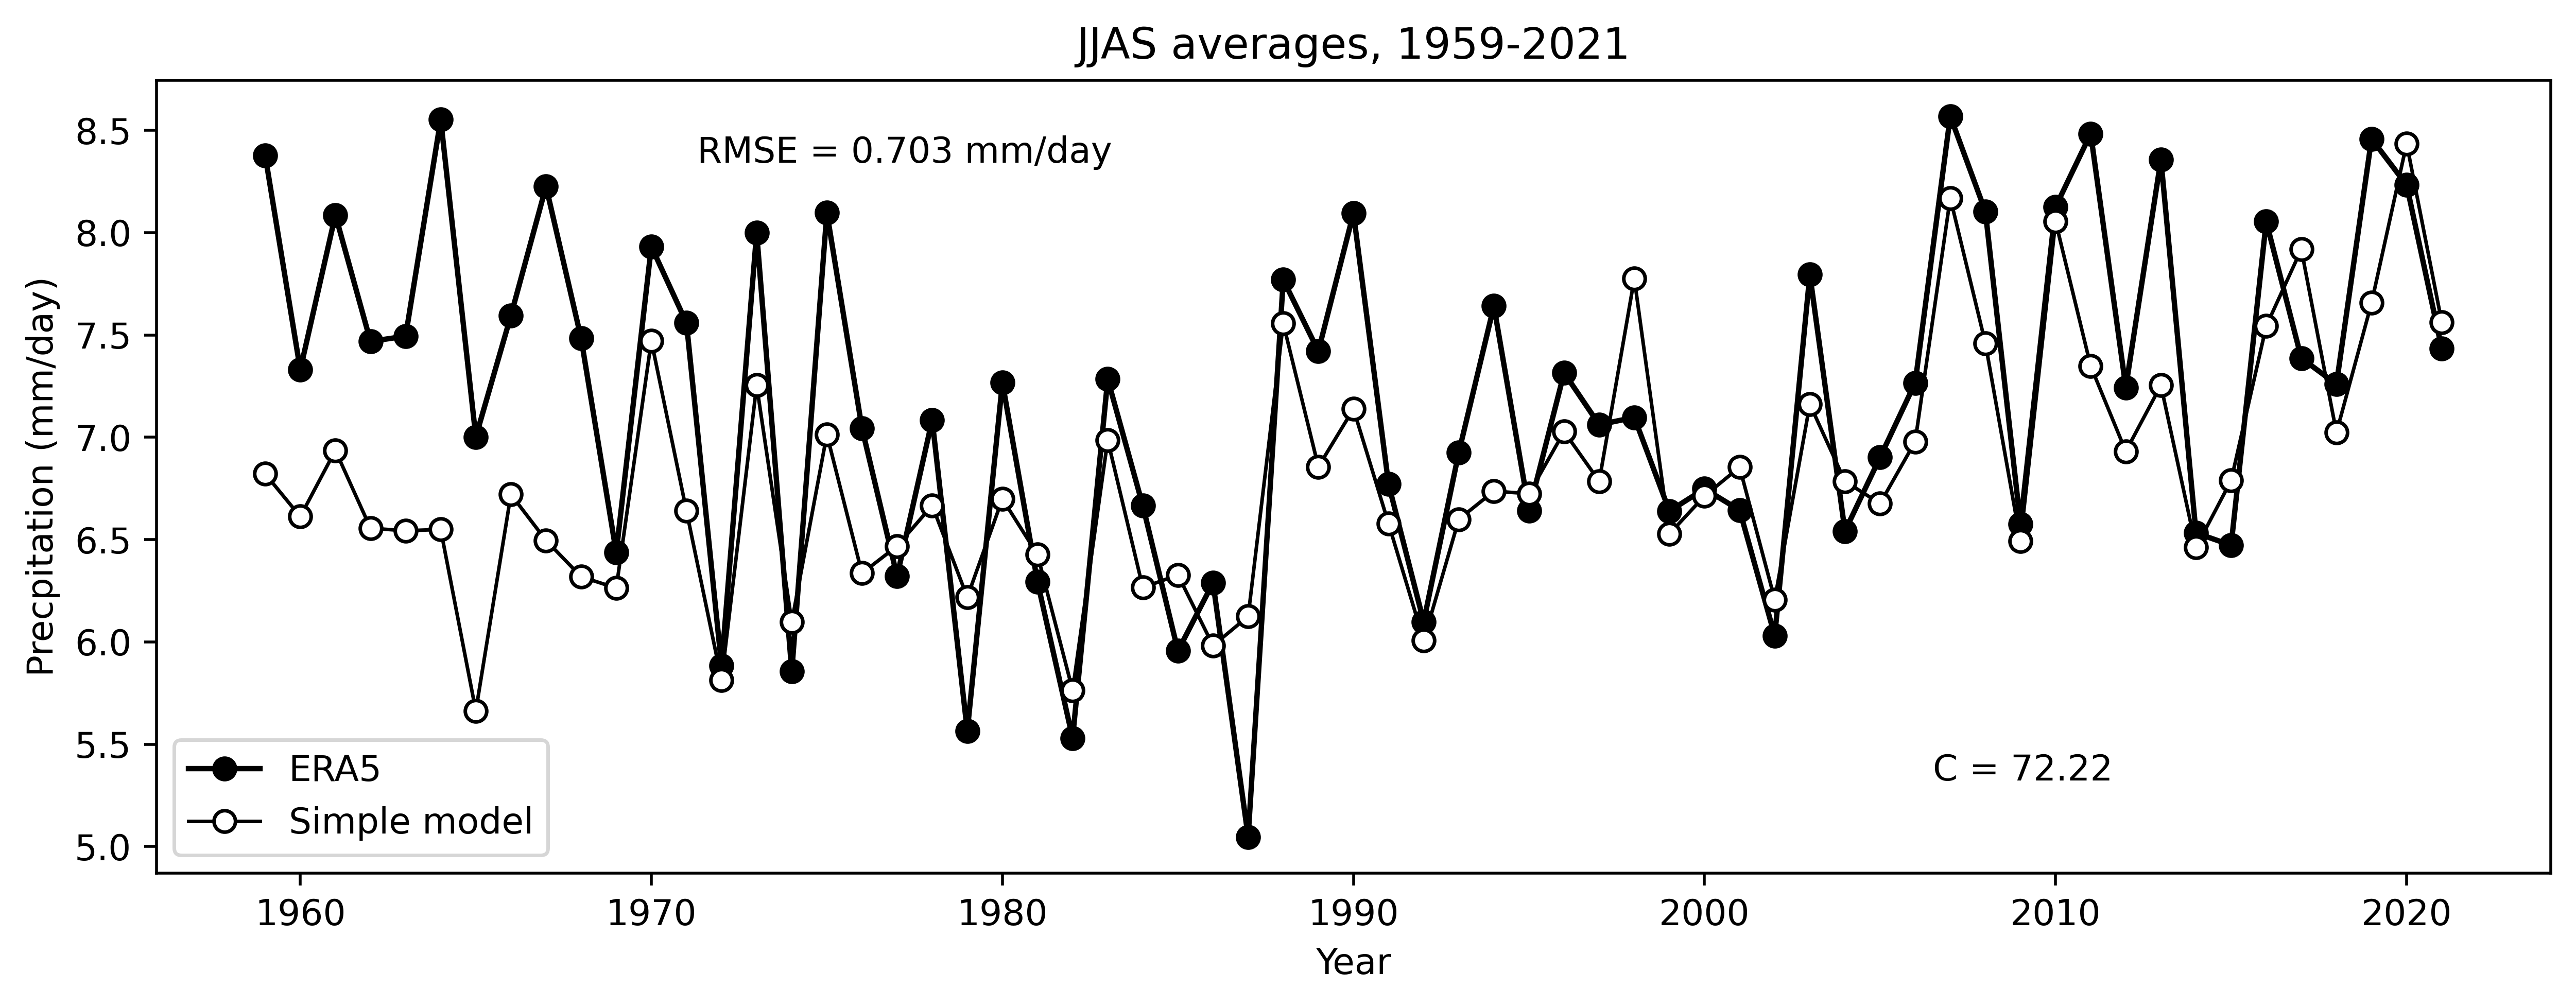

In [96]:
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(X, 86400*clim3.mtpr, color='black', label = 'ERA5', marker='o')
Pcal.plot(c='black', marker='o', markerfacecolor='white', linewidth=1, label='Simple model')
plt.xlabel('Year')
plt.ylabel('Precpitation (mm/day)')
plt.legend()
#plt.xticks(X, X)
#plt.xticks(rotation=90)
plt.figtext(0.3, 0.8, 'RMSE = %.3f mm/day' %(rmse))
plt.figtext(0.7, 0.2, 'C = 72.22')
plt.title('JJAS averages, 1959-2021')
plt.show()

# IMD

In [12]:
path = '/media/rakshith/Seagate Expansion Drive/IMD' #Daily dataset
fi = '/RFone_imd_rf_1x1_*.nc'
imd=xr.open_mfdataset(path+fi)

In [13]:
lat1, lat2, lon1, lon2 = 10, 30, 70, 90
imd2 = imd.sel(TIME=slice('1959', '2021'), LATITUDE=slice(lat1,lat2), LONGITUDE=slice(lon1,lon2))

months = imd2.TIME.dt.month.isin(range(6, 10))
imd3 = imd2.sel(TIME=months)
imd3 = imd3.groupby('TIME.year').mean('TIME')

#Mask for IMD
lon_grid, lat_grid = np.meshgrid(imd2.LONGITUDE, imd2.LATITUDE) #creating a land sea mask
imdmask = globe.is_land(lat_grid, lon_grid)

imd4 = imd3.where(imdmask>0).mean(dim=['LONGITUDE', 'LATITUDE']) #Spatial averaging over land points only

In [14]:
Pimd = 28.96*(imd4.RAINFALL.values+86400*clim3.mer)
TGMSnew = np.divide(Qdiv, Pimd)

x1, y1 = rec.values, TGMSnew

popt1, _ = curve_fit(objective, x1, y1)
# summarize the parameter values
a1, b1, c1 = popt1

print('y = %.5f * x\u00b2  %.5f * x + %.5f' % (a1, b1, c1)) #ERA5


x_line = np.linspace(np.min(x1), np.max(x1), 100)
y_line1 = objective(x_line, a1, b1, c1)

y = 25178.05449 * x²  -963.86930 * x + 9.64399


Text(0.5, 1.0, 'JJAS average 1959-2021')

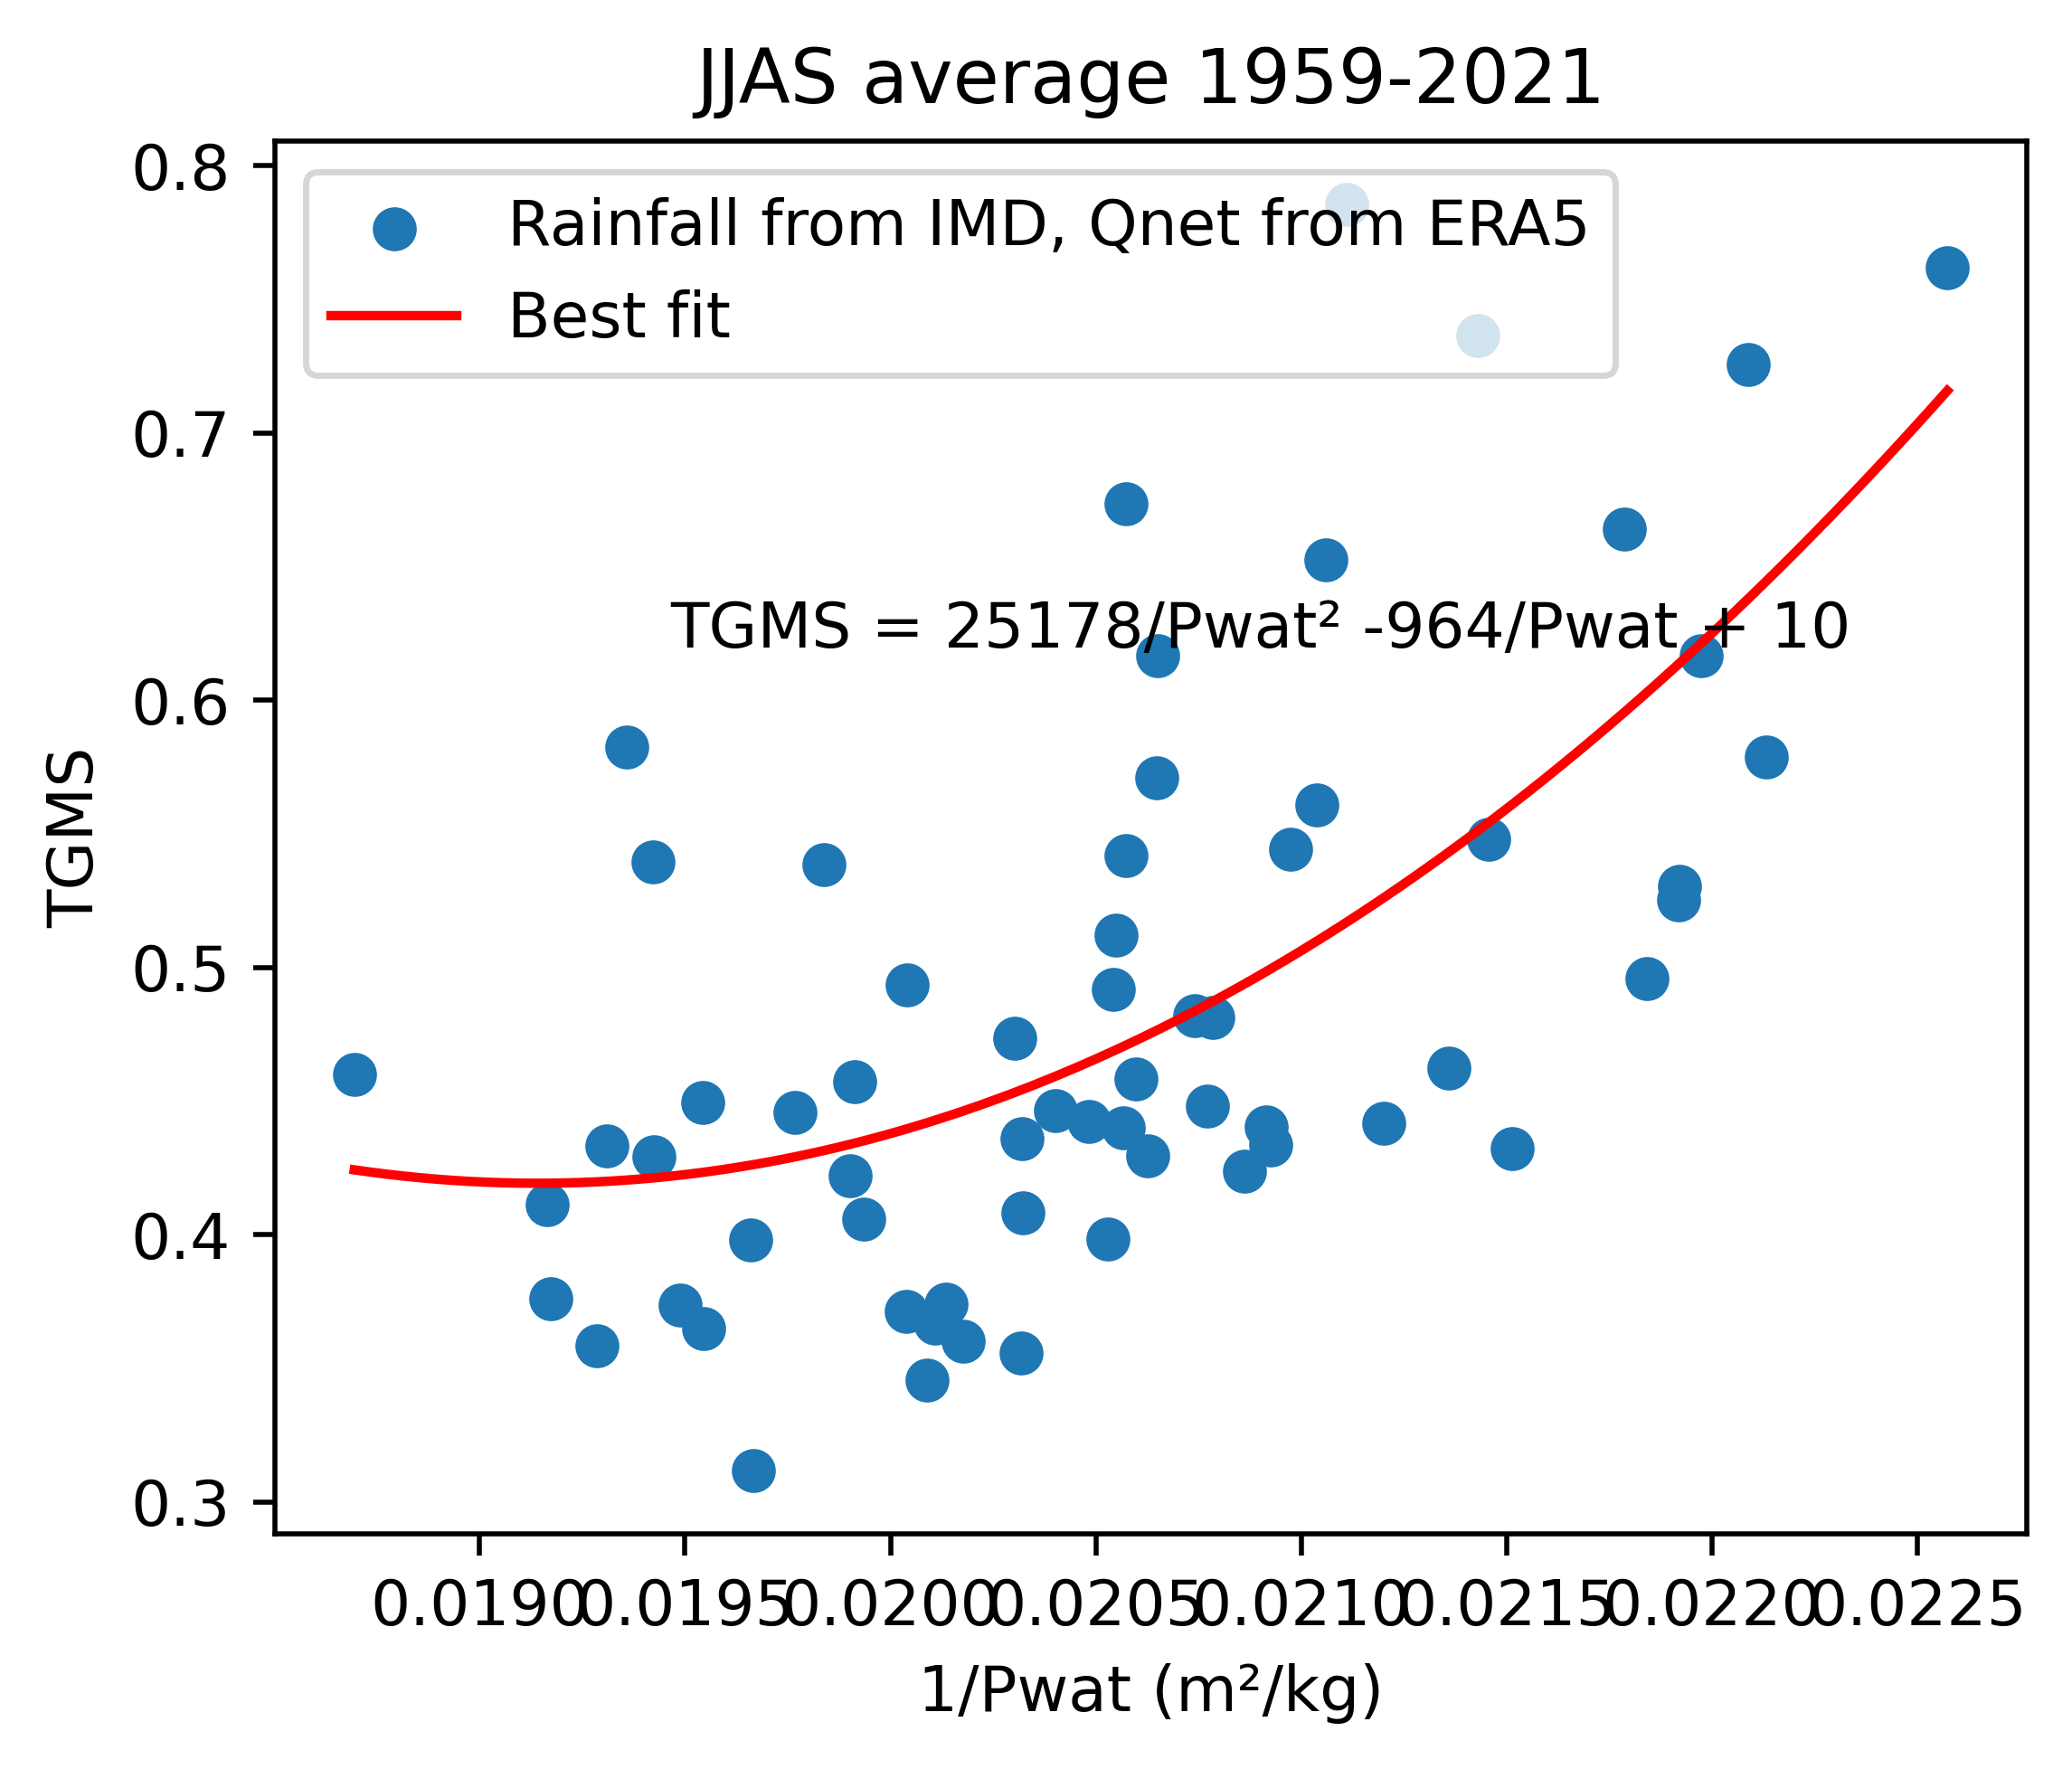

In [15]:
plt.rcParams['figure.figsize'] = [5,4]
plt.scatter(rec, TGMSnew, label ='Rainfall from IMD, Qnet from ERA5')
plt.plot(x_line, y_line1, color='red', label = "Best fit")
plt.ylabel('TGMS')
plt.xlabel('1/Pwat (m\u00b2/kg)')
plt.figtext(0.3, 0.6, 'TGMS = %0.f/Pwat\u00b2 %0.f/Pwat + %0.f' %(a1, b1, c1))
plt.legend()
plt.title('JJAS average 1959-2021')

In [16]:
y_line1 = objective(np.array(x1), a1, b1, c1) #These are calculated TGMS values
Pcal = []
for i in range(len(P)):
	Pcal.append(Qdiv[i]/y_line1[i])

X1 = np.linspace(1959, 2014, 56, dtype='int')

def f(X, c1, c2):
	x1,y1 = X
	return (x1*y1)/(c1-c2*y1)

p0 = 80, 1
X1=Qdiv
Y1=Pwat
Z1=P
popt1, pcov1 = opt.curve_fit(f, (X1, Y1), Z1, p0)

c1, c2= popt1

pred1 = np.array([])
for i in range(len(P)):
	pred1 = np.append(pred1, (X1[i]*Y1[i])/(c1-c2*Y1[i]))

In [17]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(Pimd/28.96, np.array(Pcal)/28.96, squared=False)
print(rmse)

0.6267631827425822


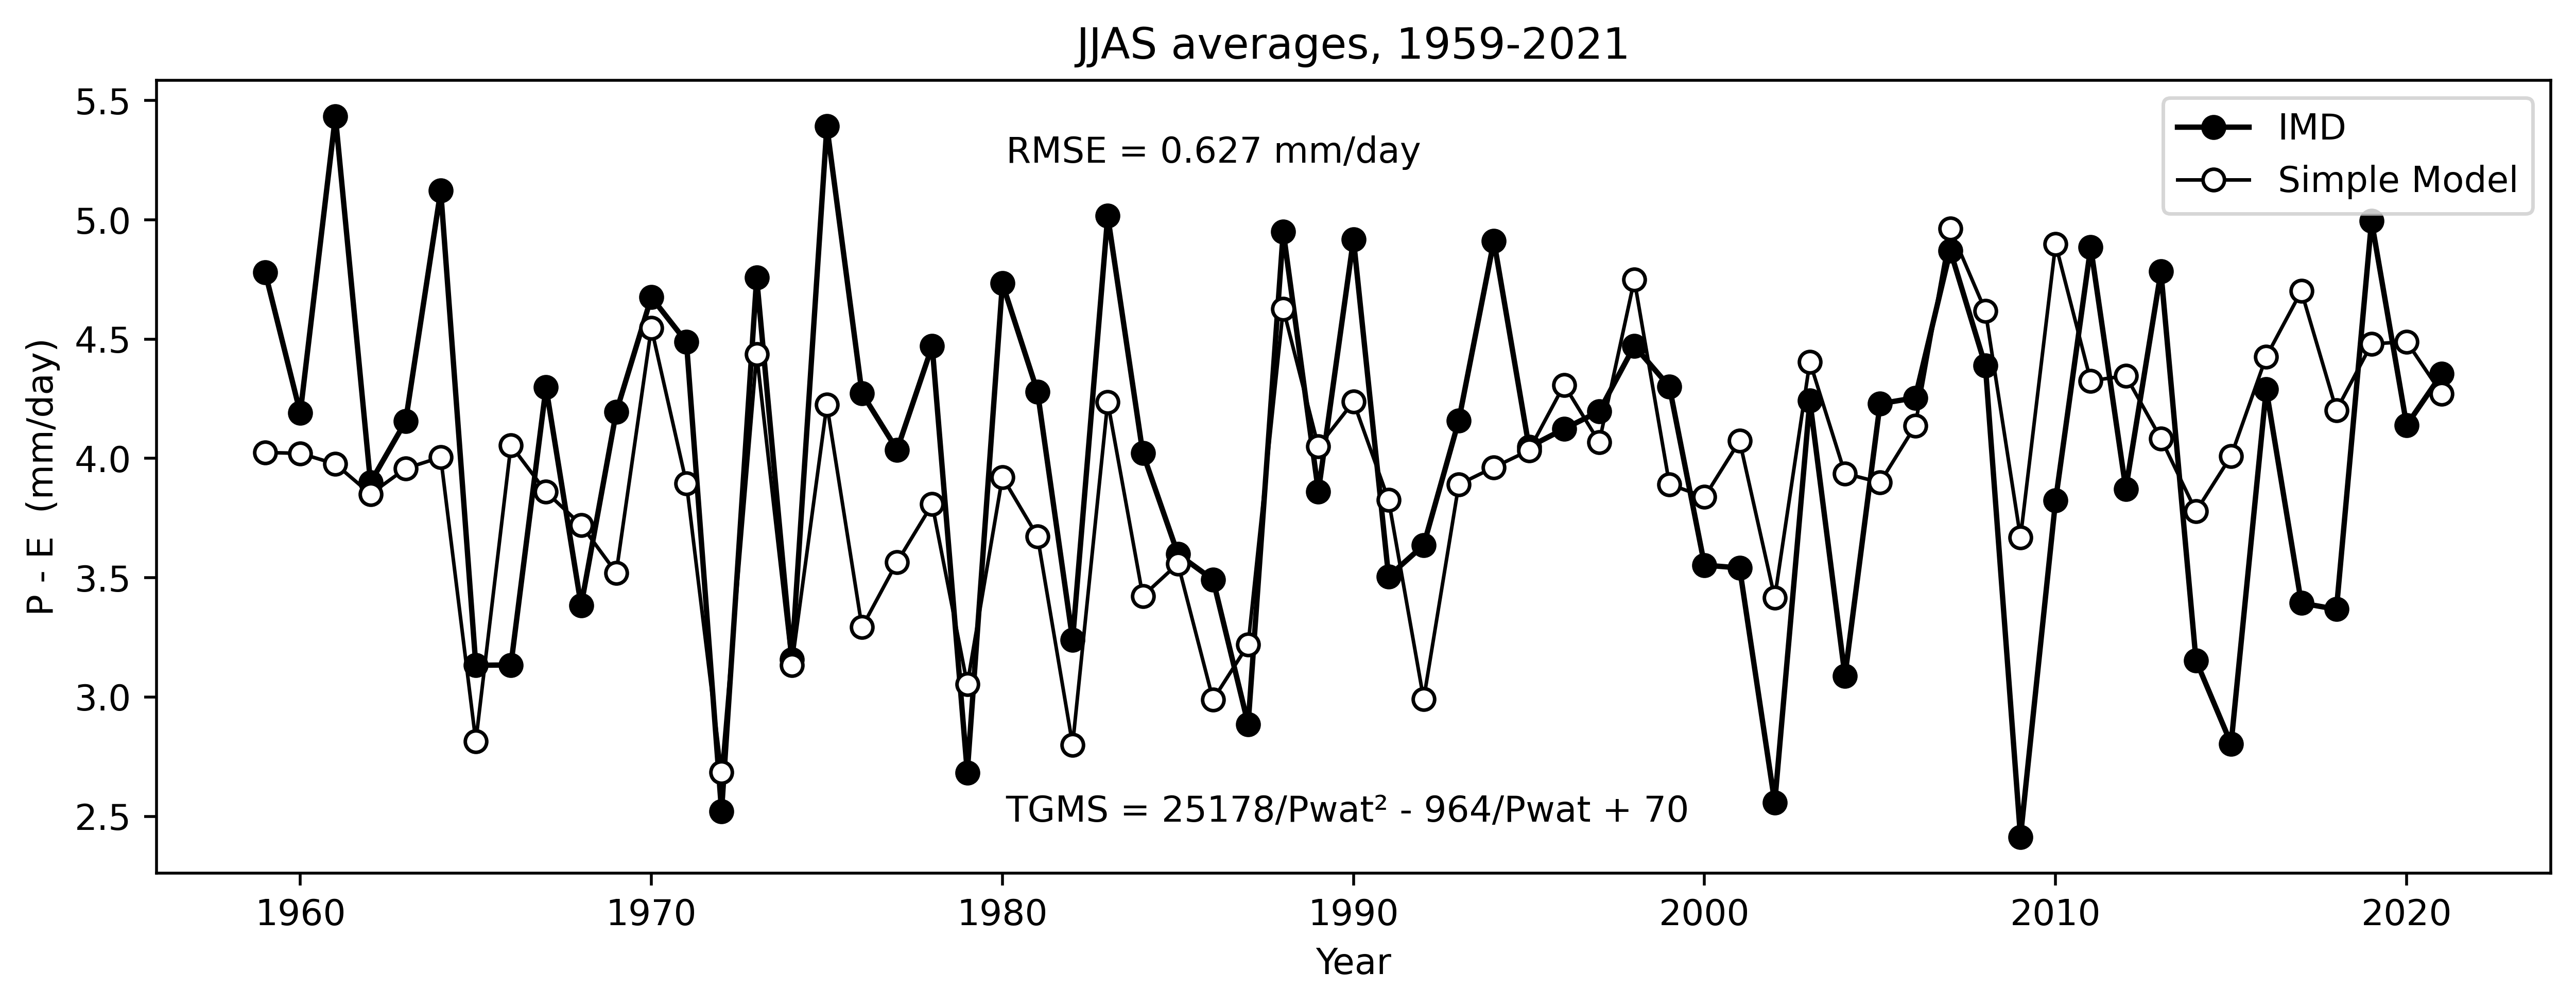

In [18]:
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(X, Pimd/28.96, color='black', label = 'IMD', marker='o')
plt.plot(X, np.array(Pcal)/28.96, c='black', marker='o', markerfacecolor='white', linewidth=1, label='Simple Model')
plt.xlabel('Year')
plt.ylabel('P - E  (mm/day)')
plt.figtext(0.4, 0.16, 'TGMS = %0.f/Pwat\u00b2 - %0.f/Pwat + %0.f' %(a1, abs(b1), c1))
plt.legend()
#plt.xticks(X, X)
#plt.xticks(rotation=90)
plt.figtext(0.4, 0.8, 'RMSE = %.3f mm/day' %(rmse))
plt.title('JJAS averages, 1959-2021')
plt.show()

# VMS

In [37]:
a = '/media/rakshith/Seagate Expansion Drive/mraks/MSE India.nc'
ds2 = xr.open_dataset(a)

g = metpy.constants.earth_gravity
Cp = metpy.constants.dry_air_spec_heat_press
Lv = metpy.constants.water_heat_vaporization

In [38]:
jjas = ds2.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds2.sel(time=jjas)
clim = clim.groupby('time.year').mean('time')
clim3 = clim.where(mask>0).mean(dim=['latitude', 'longitude'])

In [39]:
#M = 100*mpcalc.moist_static_energy(clim3.z*units('m^2/s^2')/g, clim3.t*units.kelvin, clim3.q)
M = Cp*clim3.t*units('K')+Lv*clim3.q + clim3.z*units('m^2/s^2')
m1 = M.sel(level=200)
m2 = M.sel(level=850)
VMS=m1-m2
vpwat = np.divide(VMS, Pwat)

Text(0.5, 0.98, 'JJAS average 1959-2021, ERA5')

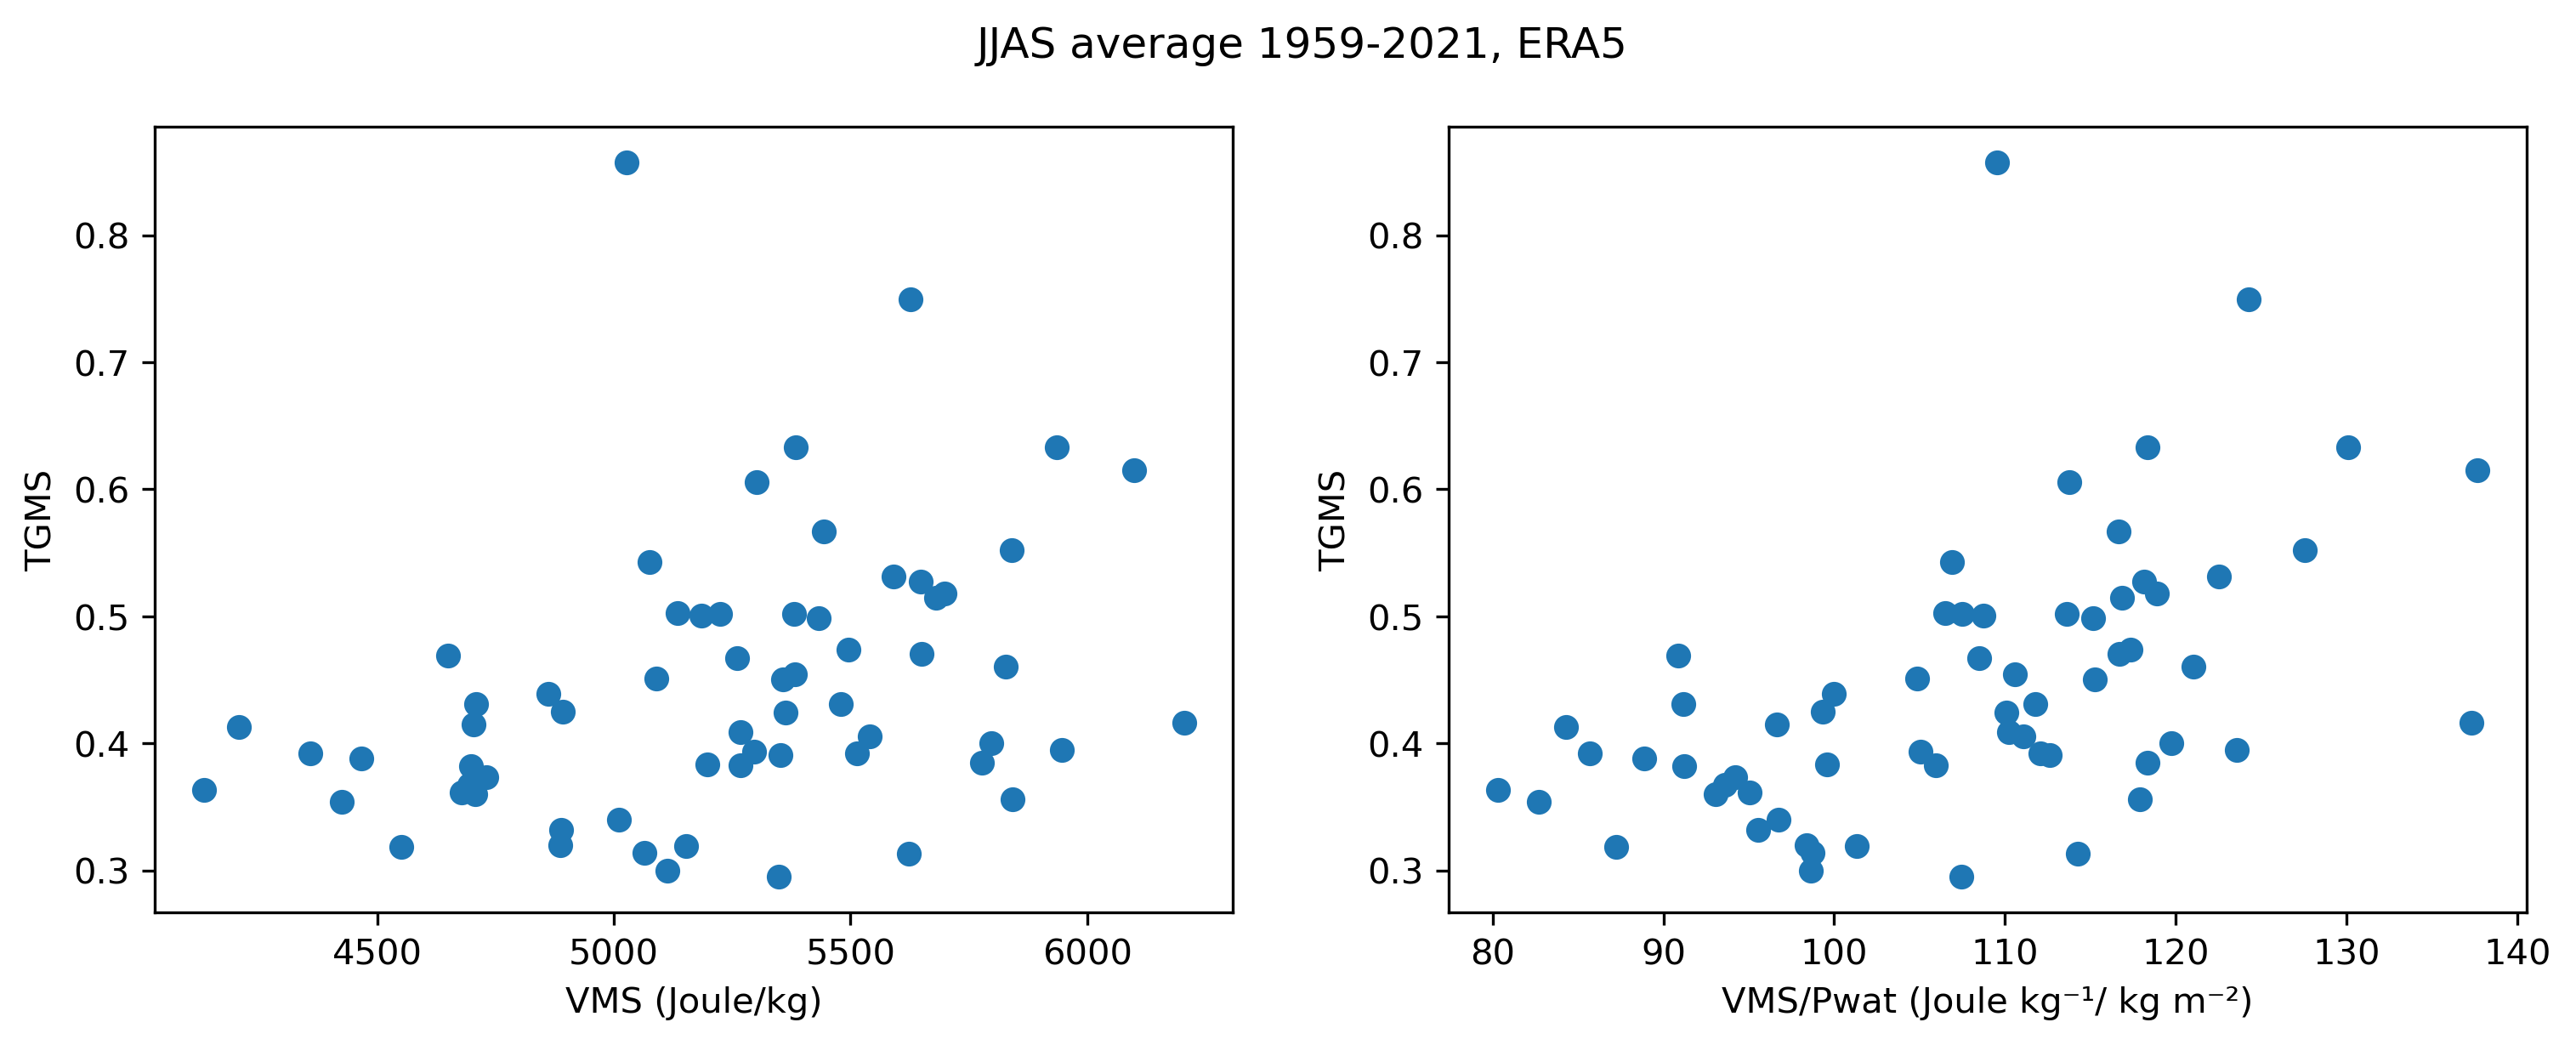

In [40]:
plt.rcParams['figure.figsize'] = [12,4]
plt.subplot(1,2,1)
plt.scatter(VMS, TGMS)
plt.ylabel('TGMS')
plt.xlabel('VMS (Joule/kg)')

plt.subplot(1,2,2)
plt.scatter(vpwat, TGMS)
plt.ylabel('TGMS')
plt.xlabel('VMS/Pwat (Joule kg\u207B\u00B9/ kg m\u207B\u00B2)')

plt.suptitle('JJAS average 1959-2021, ERA5')